In [23]:
import chaospy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from scipy.special import kl_div

# Model

In [24]:
def model_solver(params):
    p, t, r = params
    E = 128
    E = E*10**6
    nu = 0.24839
    p = p*6894.757
    t = t*10**-6
    r = r*10**-3
    sigma = -np.sqrt(2)/9*E*t/r*np.sqrt(1/(1 - nu**2) + 4*p/E*(r/t)**2)
    return p*np.pi*r**2 - 2*np.pi*t*r*sigma

In [25]:
# 输入分布
p = chaospy.Normal(20, 1.5)
t = chaospy.Uniform(64, 66)
r = chaospy.Uniform(8.48, 8.52)
joint = chaospy.J(p, t, r)

In [26]:
samples = joint.sample(1000, rule="sobol")  # 取样1000
evaluations = np.array([model_solver(sample) for sample in samples.T])
evaluations.shape

(1000,)

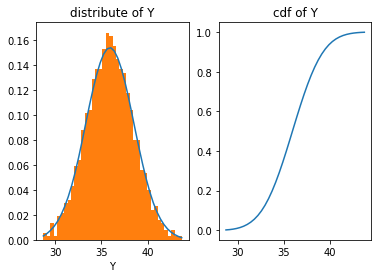

In [27]:
dist = chaospy.GaussianKDE(evaluations)
Y = np.linspace(evaluations.min(), evaluations.max(), 40)
plt.subplot(121)
plt.plot(Y, dist.pdf(Y))
plt.hist(evaluations, bins=40, density=True)
plt.xlabel("Y")
plt.title("distribute of Y")
plt.subplot(122)
plt.plot(Y, dist.cdf(Y))
plt.title("cdf of Y")
plt.show()

# fusion

In [28]:
mu = 7
sigma = 3
p = chaospy.Normal(mu, sigma)
t = chaospy.Uniform(64, 66)
r = chaospy.Uniform(8.48, 8.52)
joint = chaospy.J(p, t, r)
ss = joint.sample(100,rule="sobol")
ss.sort()
ss[0]

array([ 0.53837592,  1.03771634,  1.4118044 ,  1.71498877,  1.97218083,
        2.19697401,  2.39763837,  2.74660859,  2.90138855,  3.04596731,
        3.31042372,  3.43250695,  3.54895186,  3.7674533 ,  3.87052521,
        3.97002949,  4.15965473,  4.25033   ,  4.33856032,  4.50846737,
        4.5904823 ,  4.67073472,  4.82645685,  4.90215009,  4.97653075,
        5.12170296,  5.19265164,  5.26260351,  5.33162322,  5.39977088,
        5.46710258,  5.53367077,  5.66471043,  5.72927175,  5.7932498 ,
        5.91961032,  5.98206518,  6.04408191,  6.16692868,  6.22781942,
        6.28839367,  6.34867916,  6.40870275,  6.46849054,  6.52806795,
        6.64669038,  6.70578354,  6.76476276,  6.88247174,  6.94124714,
        7.        ,  7.11752826,  7.17634881,  7.23523724,  7.29421646,
        7.35330962,  7.41254021,  7.47193205,  7.59129725,  7.65132084,
        7.71160633,  7.83307132,  7.89430724,  7.95591809,  8.08038968,
        8.14331636,  8.2067502 ,  8.33528957,  8.40047537,  8.46

In [29]:
def f0(params):
    mu = params[0]
    sigma = params[1]
    p = chaospy.Normal(mu, sigma)
    t = chaospy.Uniform(64, 66)
    r = chaospy.Uniform(8.48, 8.52)
    joint = chaospy.J(p, t, r)
    n_samples = 1_00
    test = joint.sample(n_samples,rule="sobol")
    sampes = np.array([model_solver(sample) for sample in test.T])
    return chaospy.GaussianKDE(sampes)

结合实验

In [30]:
exp_Y = np.asarray([13.43, 17.47, 14.22, 10.80, 10.24833, 13.79])
exp_Y.sort()
y_cum = np.arange(1, len(exp_Y) + 1) / len(exp_Y)

def exp_cdf(x, epsilon):
    # epsilon = 0.1
    for i in range(len(exp_Y)):
        if i == len(exp_Y) - 1:
            return 1
        if x < exp_Y[0]:
            return 0
        if (x >= exp_Y[i]) & (x < exp_Y[i + 1]):
            return max(min(y_cum[i] + epsilon, 1), 0)

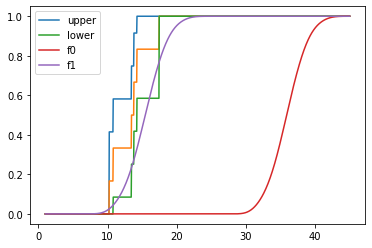

In [31]:
Y = np.linspace(1, 45, 1000)
plt.plot(Y, [exp_cdf(i, 0.2483) for i in Y], label="upper")
plt.plot(Y, [exp_cdf(i, 0) for i in Y])
plt.plot(Y, [exp_cdf(i, -0.2483) for i in Y], label="lower")
plt.plot(Y, f0([20,1.5]).cdf(Y), label="f0")
plt.plot(Y, f0([8,1.5]).cdf(Y), label="f1")
plt.legend()

In [32]:
def obj_func(params, exp_Y=0):
    mu = params[0]
    sigma = params[1]
    SMALL = 1e-10
    Y = np.linspace(0, 45, 200)
    # return np.abs(f0([mu, sigma]).cdf(Y) - f0([20, 1.5]).cdf(Y)).max()
    return sum(kl_div(f0([mu, sigma]).pdf(Y) + SMALL, f0([20, 1.5]).pdf(Y) + SMALL)) / len(Y)

print(f"{obj_func([10, 1.5])=},{obj_func([20, 1.5])=}")

obj_func([10, 1.5])=0.45500276733295775,obj_func([20, 1.5])=0.0


In [33]:
cons = []
for i in range(4):
    cons.append({
        "type": "ineq",
        "fun": lambda x, exp_Y: exp_cdf(exp_Y[i], epsilon=0.2483) - f0(x).cdf(exp_Y[i]),
        "args": (exp_Y,),
    })
    cons.append({
        "type": "ineq",
        "fun": lambda x, exp_Y: f0(x).cdf(exp_Y[i]) - exp_cdf(exp_Y[i], epsilon=-0.2483),
        "args": (exp_Y,),
    })
cons.append({
    "type": "ineq",
    "fun": lambda x, exp_Y: x[0] - 7,
    "args": (exp_Y,),
    })
cons.append({
    "type": "ineq",
    "fun": lambda x, exp_Y: 50 - x[0],
    "args": (exp_Y,),
    })
cons.append({
    "type": "ineq",
    "fun": lambda x, exp_Y: x[1],
    "args": (exp_Y,),
    })
cons.append({
    "type": "ineq",
    "fun": lambda x, exp_Y: 3 - x[1],
    "args": (exp_Y,),
    })
cons = tuple(cons)

最小化KL散度

In [34]:
# res = minimize(obj_func, x0, args=(exp), method="trust-constr", constraints=cons,)
x0 = np.array([10, 1.5])
res = minimize(obj_func, x0, args=(exp_Y), method="COBYLA", constraints=cons,)
# res = minimize(obj_func, x0, args=(exp_Y), method="SLSQP", constraints=cons)
# res = minimize(obj_func, x0, method="nelder-mead")
res

     fun: 0.4338104493685239
   maxcv: 2.216032372048815e-07
 message: 'Optimization terminated successfully.'
    nfev: 18
  status: 1
 success: True
       x: array([7.71206803, 3.        ])

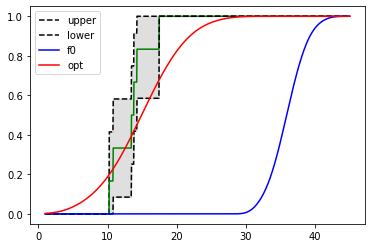

In [35]:
plt.plot(Y, [exp_cdf(i, 0.2483) for i in Y], "k--", label="upper")
plt.plot(Y, [exp_cdf(i, 0) for i in Y], "g")
plt.plot(Y, [exp_cdf(i, -0.2483) for i in Y], "k--", label="lower")
plt.fill_between(
    Y,
    [exp_cdf(i, 0.2483) for i in Y],
    [exp_cdf(i, -0.2483) for i in Y],
    alpha=0.2483,
    color="grey",
)

plt.plot(Y, f0([20, 1.5]).cdf(Y), "b", label="f0")
plt.plot(Y, f0(res.x).cdf(Y), "r", label="opt")
plt.legend()

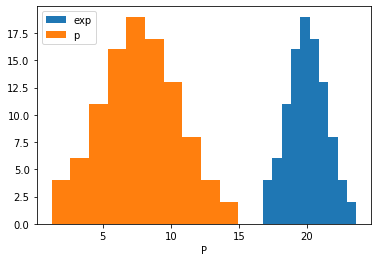

In [36]:
p_t = chaospy.Normal(res.x[0],res.x[1])
p_e = chaospy.Normal(20, 1.5)
plt.hist(p_e.sample(100,rule='sobol'), label="exp")
plt.hist(p_t.sample(100,rule='sobol'), label="p")
plt.xlabel("P")
plt.legend()
plt.show()

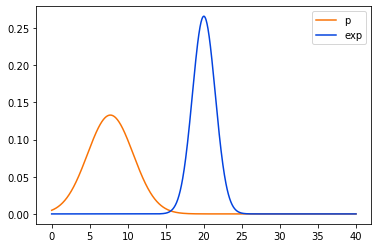

In [37]:
t=np.linspace(0,40,1000)
plt.plot(t,p_t.pdf(t),'xkcd:orange',label='p')
plt.plot(t,p_e.pdf(t),'xkcd:blue',label='exp')
plt.legend()

基于ks距离的优化

In [38]:
def obj_ks(params, exp_Y=0):
    mu = params[0]
    sigma = params[1]
    SMALL = 1e-10
    Y = np.linspace(0, 45, 200)
    return np.abs(f0([mu, sigma]).cdf(Y) - f0([20, 1.5]).cdf(Y)).max()

print(f"{obj_func([10, 1.5])=},{obj_func([20, 1.5])=}")

obj_func([10, 1.5])=0.45500276733295775,obj_func([20, 1.5])=0.0


In [39]:
# res = minimize(obj_func, x0, args=(exp), method="trust-constr", constraints=cons,)
x0 = np.array([10, 1.5])
res1 = minimize(obj_ks, x0, args=(exp_Y), method="COBYLA", constraints=cons,)
# res = minimize(obj_func, x0, args=(exp_Y), method="SLSQP", constraints=cons)
# res = minimize(obj_func, x0, method="nelder-mead")
res1

     fun: 0.9958647217796484
   maxcv: 1.2399224714743085e-06
 message: 'Optimization terminated successfully.'
    nfev: 19
  status: 1
 success: True
       x: array([7.71207615, 3.        ])

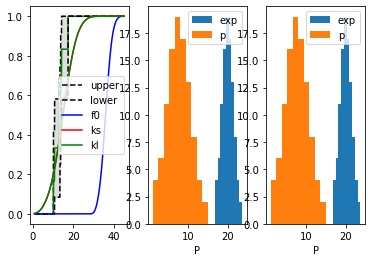

In [40]:
plt.subplot(131)
plt.plot(Y, [exp_cdf(i, 0.2483) for i in Y], "k--", label="upper")
plt.plot(Y, [exp_cdf(i, 0) for i in Y], "g")
plt.plot(Y, [exp_cdf(i, -0.2483) for i in Y], "k--", label="lower")
plt.fill_between(
    Y,
    [exp_cdf(i, 0.2483) for i in Y],
    [exp_cdf(i, -0.2483) for i in Y],
    alpha=0.2483,
    color="grey",
)
plt.plot(Y, f0([20, 1.5]).cdf(Y), "b", label="f0")
plt.plot(Y, f0(res1.x).cdf(Y), "r", label="ks")
plt.plot(Y, f0(res1.x).cdf(Y), "g", label="kl")
plt.legend()

plt.subplot(132)
p_t = chaospy.Normal(res1.x[0],res1.x[1])
p_e = chaospy.Normal(20, 1.5)
plt.hist(p_e.sample(100,rule='sobol'), label="exp")
plt.hist(p_t.sample(100,rule='sobol'), label="p")
plt.xlabel("P")
plt.legend()
plt.subplot(133)
p_t = chaospy.Normal(res.x[0],res.x[1])
p_e = chaospy.Normal(20, 1.5)
plt.hist(p_e.sample(100,rule='sobol'), label="exp")
plt.hist(p_t.sample(100,rule='sobol'), label="p")
plt.xlabel("P")
plt.legend()
plt.show()
plt.show()